In [1]:
from __future__ import absolute_import, division, print_function

import sys
import os
import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# 绘图
import matplotlib.pylab as plt
import seaborn as sns
#一些参数风格设置
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set(style='ticks', context='poster')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

             UMCSENT
DATE                
2000-01-01 112.00000
2000-02-01 111.30000
2000-03-01 107.10000
2000-04-01 109.20000
2000-05-01 110.70000


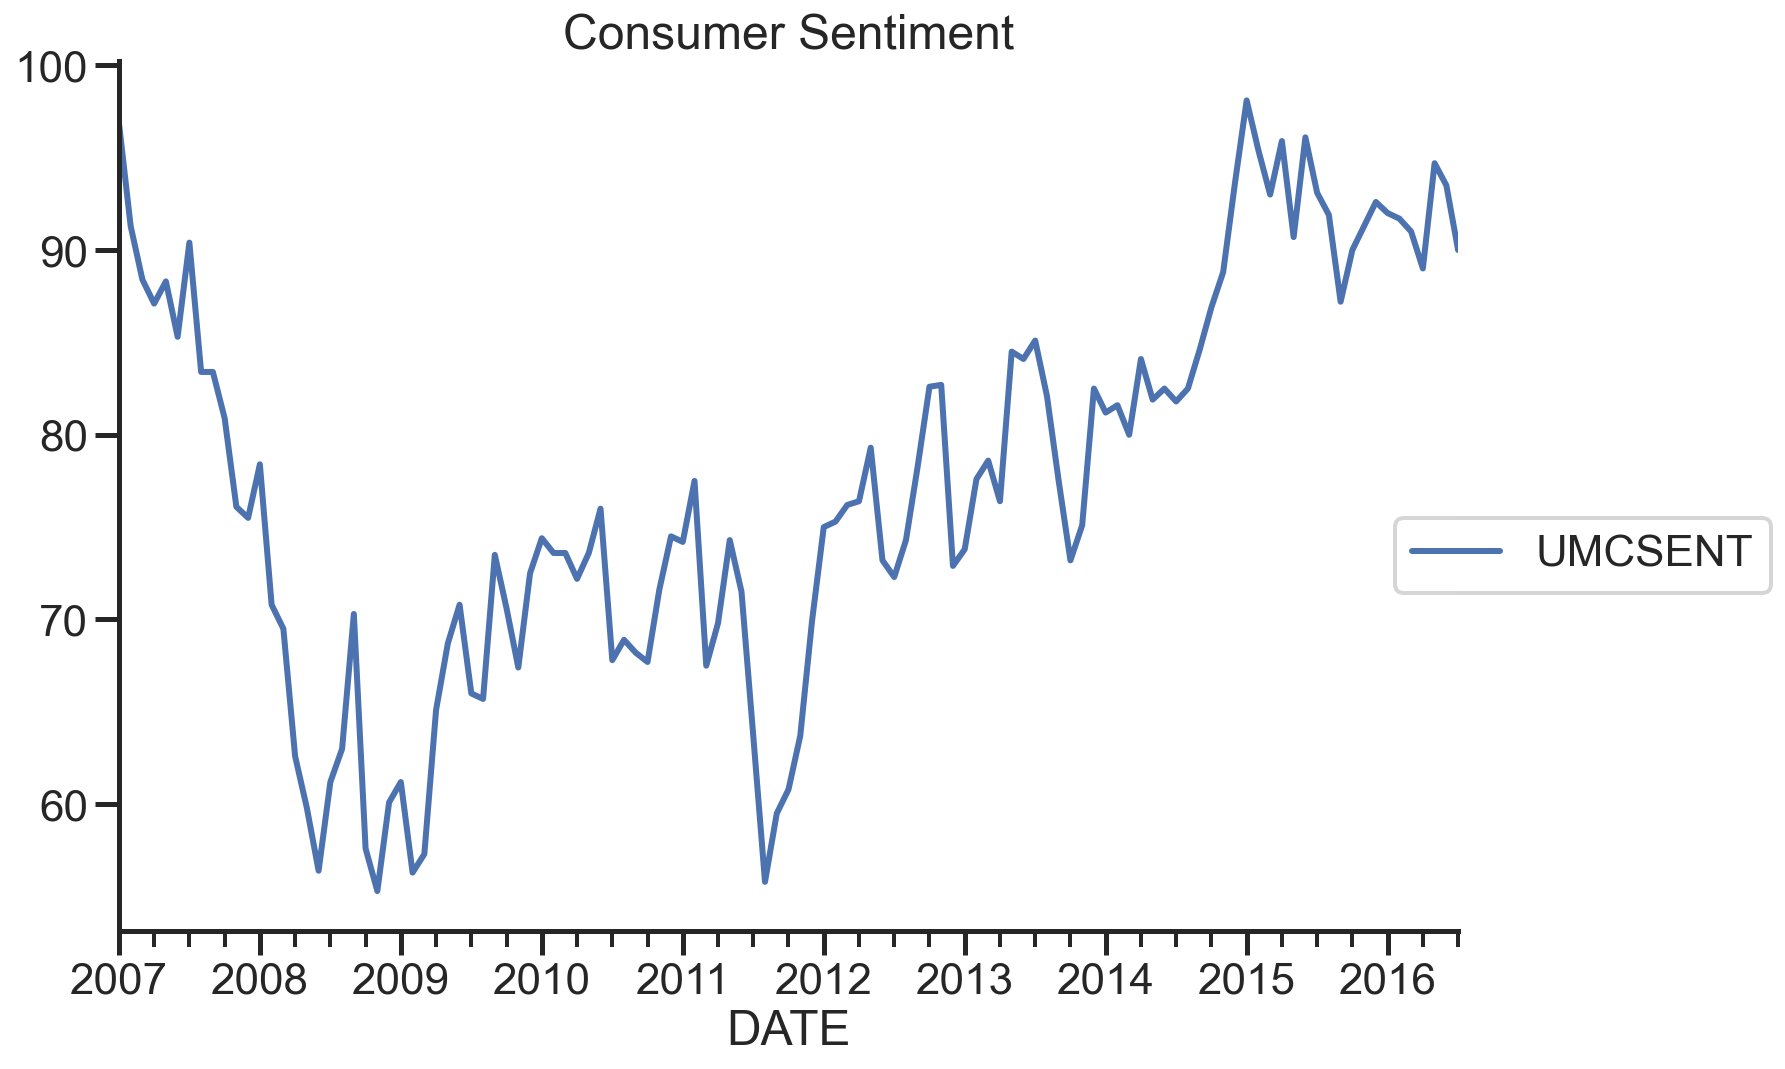

In [3]:
#数据读取
Sentiment = pd.read_csv('sentiment.csv',index_col=0, parse_dates=[0])
print(Sentiment.head())
#切分为测试数据和训练数据
n_sample = Sentiment.shape[0]
n_train = int(0.95 * n_sample)+1
n_forecast = n_sample - n_train
ts_train = Sentiment.iloc[:n_train]['UMCSENT']
ts_test = Sentiment.iloc[:n_forecast]['UMCSENT']
#截取10年数据并展示
sentiment_short = Sentiment.loc['2007':'2017']
sentiment_short.plot(figsize = (12,8))
plt.title("Consumer Sentiment")
plt.legend(bbox_to_anchor = (1.25,0.5))
sns.despine()
plt.show()

<ipython-input-4-3b916b2984a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
<ipython-input-4-3b916b2984a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)


            UMCSENT   diff_1  diff_2
DATE                                
2007-01-01 96.90000      NaN     NaN
2007-02-01 91.30000 -5.60000     NaN
2007-03-01 88.40000 -2.90000 2.70000
2007-04-01 87.10000 -1.30000 1.60000
2007-05-01 88.30000  1.20000 2.50000


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

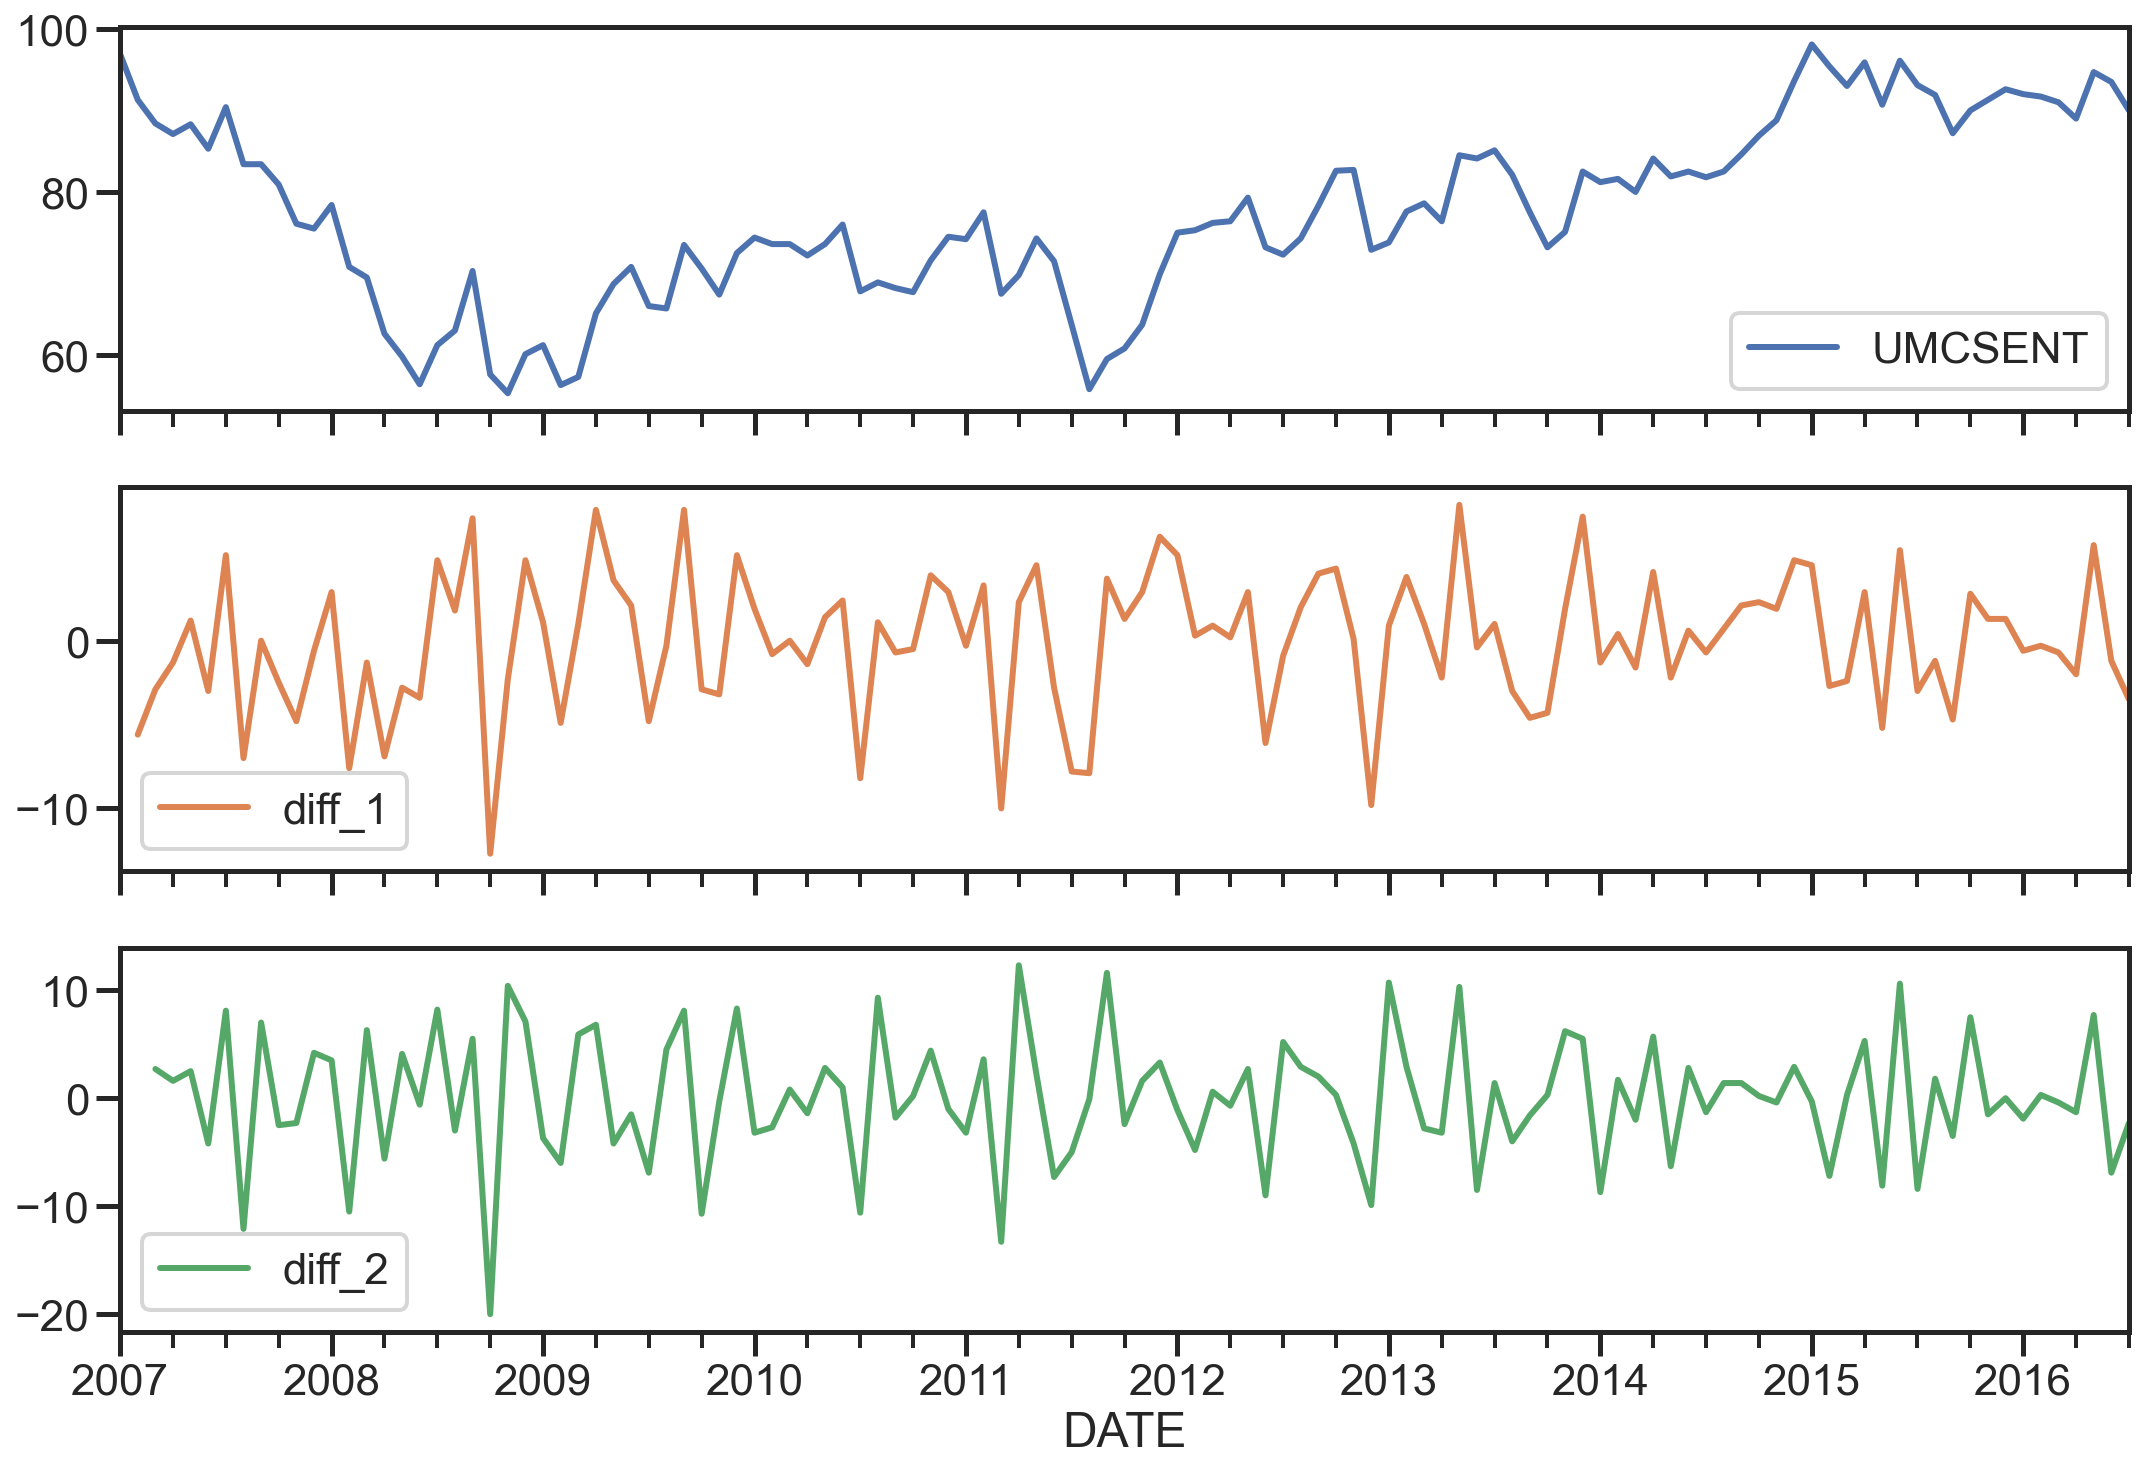

In [4]:
#一阶差分
sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
#二阶差分
sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)
print(sentiment_short.head())
sentiment_short.plot(subplots=True, figsize=(18, 12))



In [5]:
del sentiment_short['diff_2']
del sentiment_short['diff_1']
print(sentiment_short.head())
print (type(sentiment_short))

            UMCSENT
DATE               
2007-01-01 96.90000
2007-02-01 91.30000
2007-03-01 88.40000
2007-04-01 87.10000
2007-05-01 88.30000
<class 'pandas.core.frame.DataFrame'>


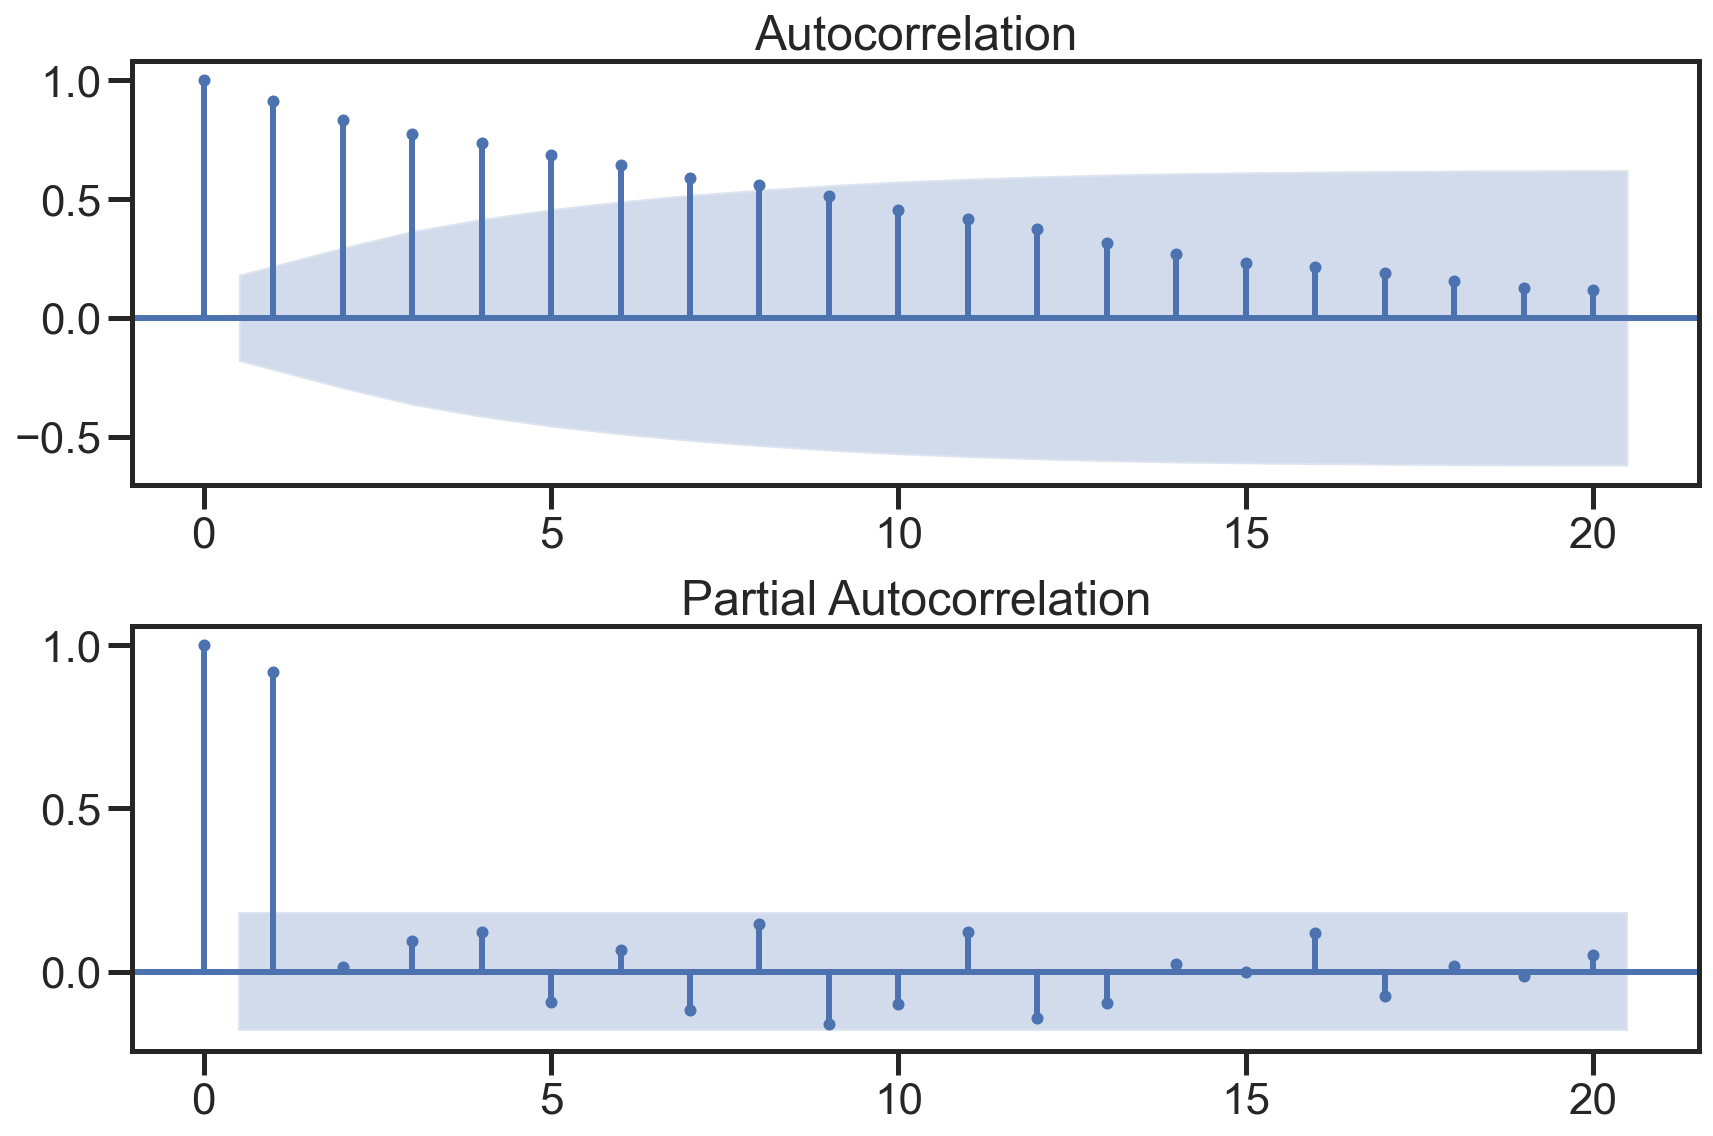

In [6]:

fig = plt.figure(figsize=(12,8))
#画ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentiment_short, lags=20,ax=ax1)#lags表示滞后的阶数
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#画PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [7]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax



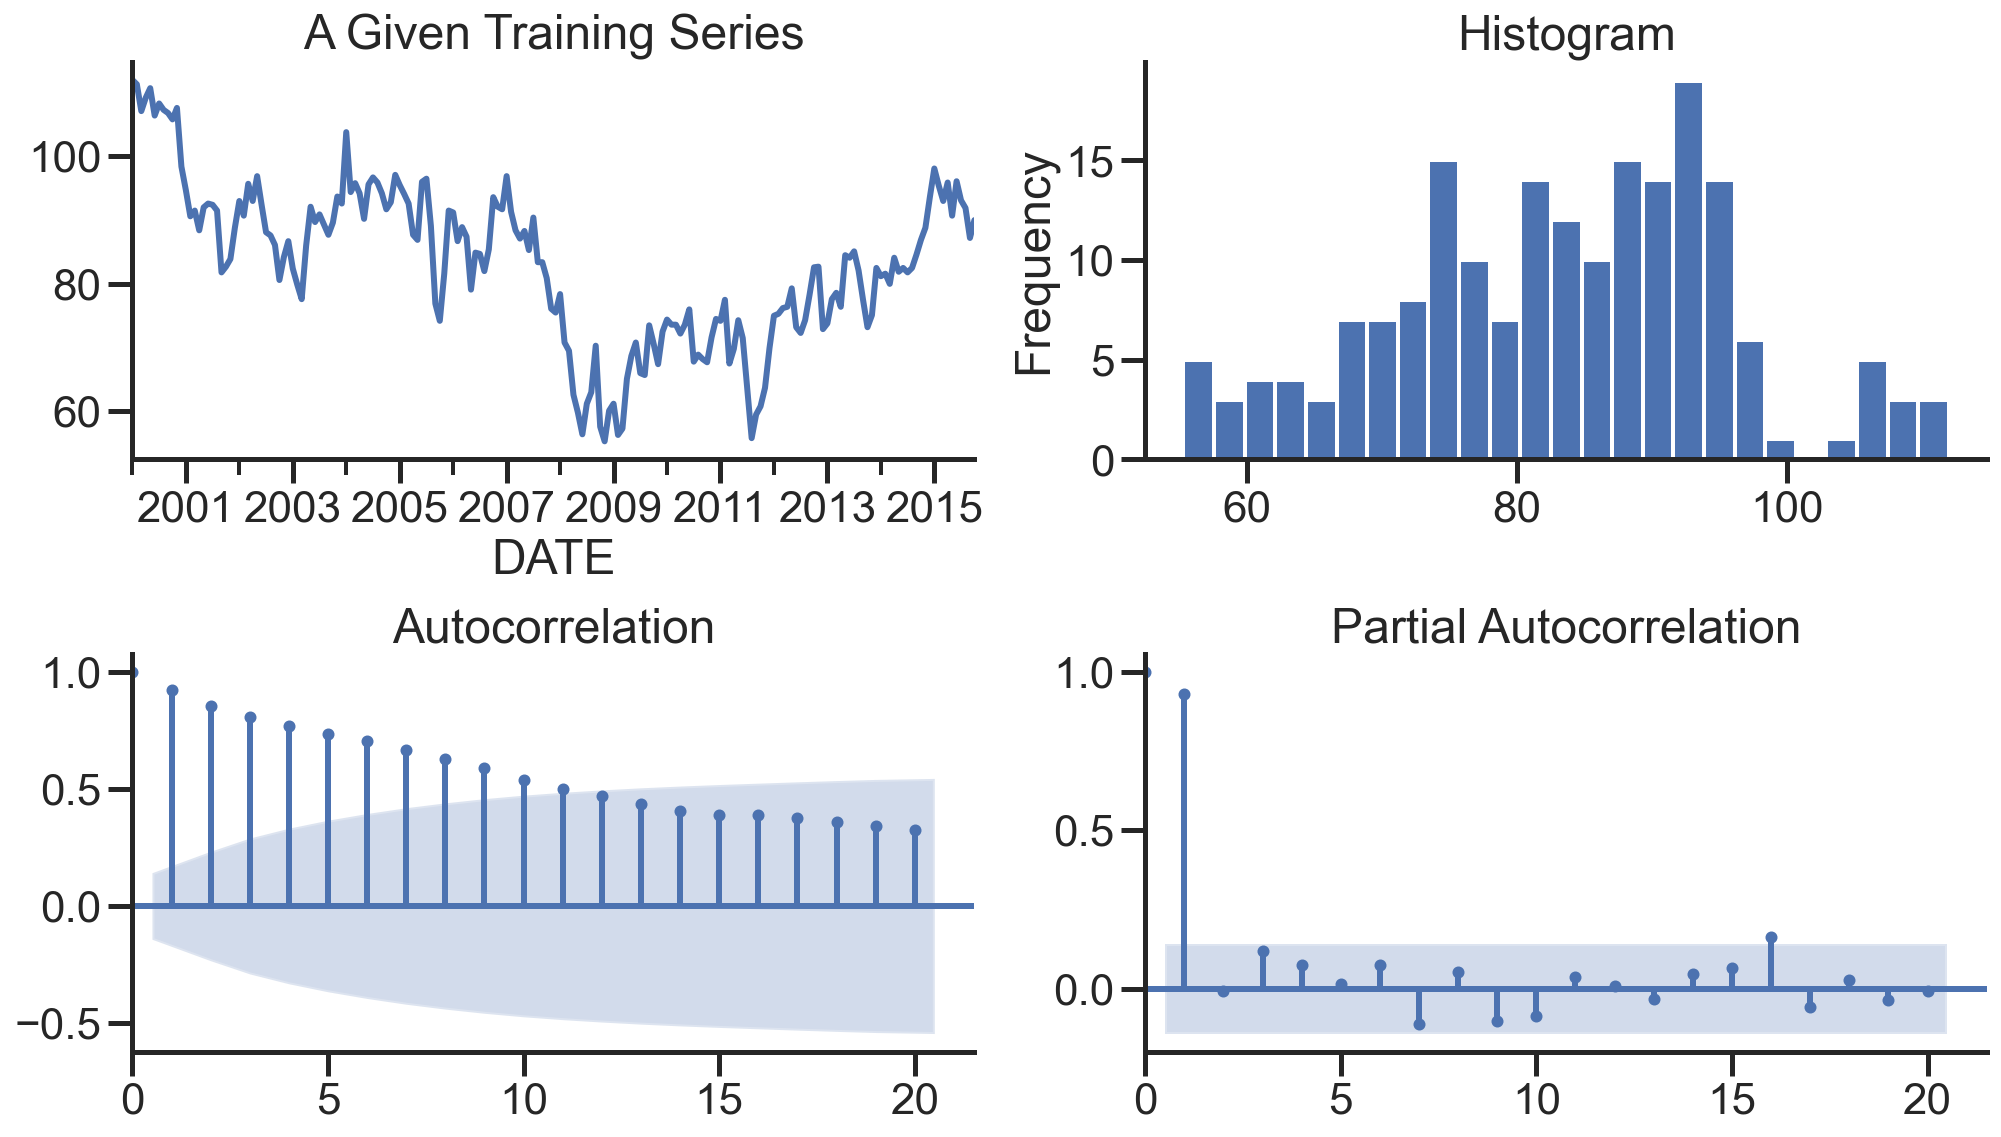

In [8]:
tsplot(ts_train, title='A Given Training Series', lags=20);

In [9]:
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
#遍历，寻找适宜的参数
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue

    try:
        model = sm.tsa.ARIMA(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)



D:\Anaconda3\envs\pt38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Anaconda3\envs\pt38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Anaconda3\envs\pt38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
w

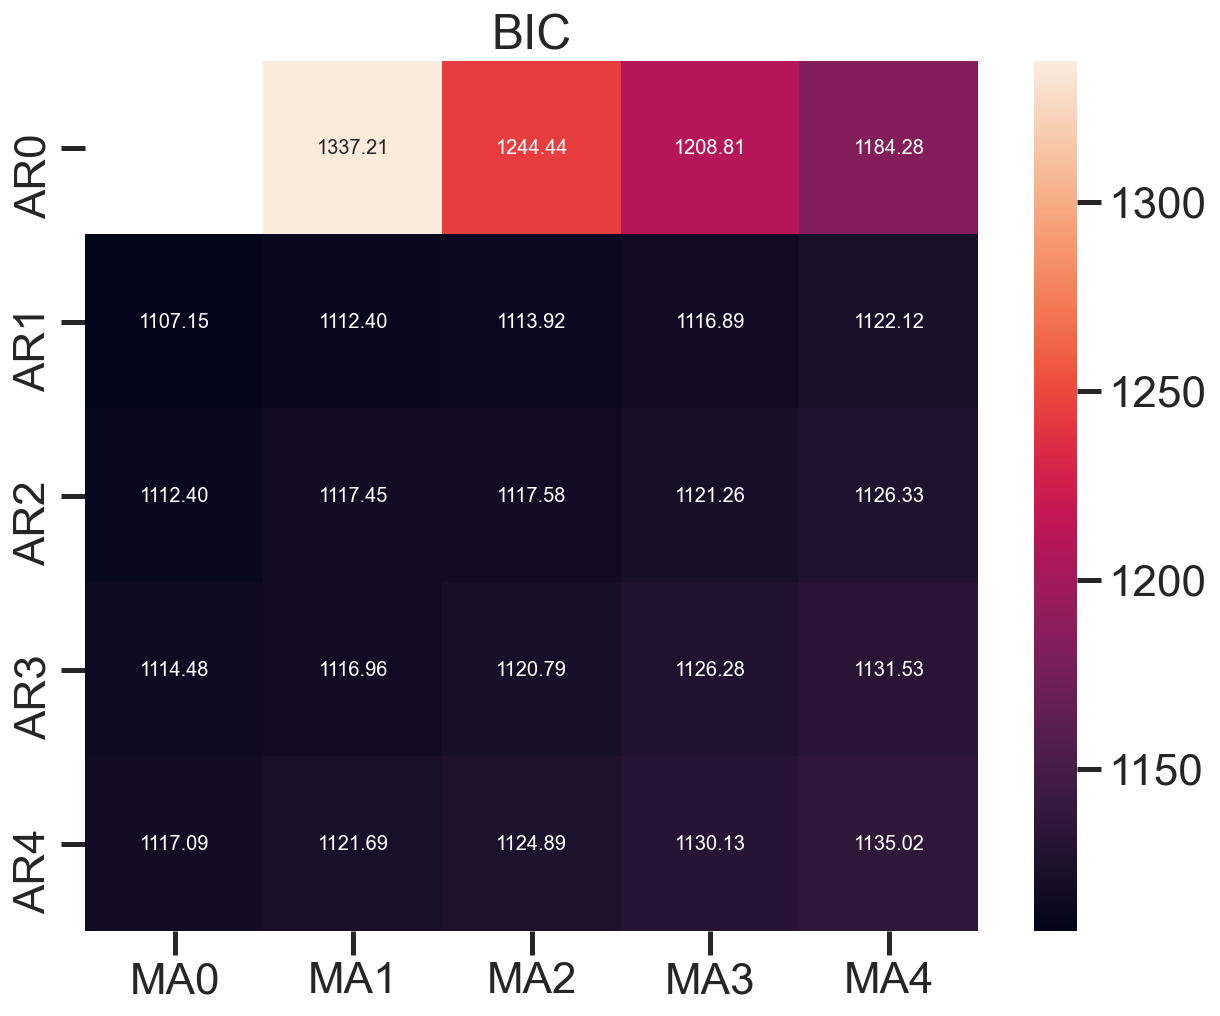

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')
plt.show()



In [11]:
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

D:\Anaconda3\envs\pt38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda3\envs\pt38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA 

AIC (4, 3)
BIC (1, 0)


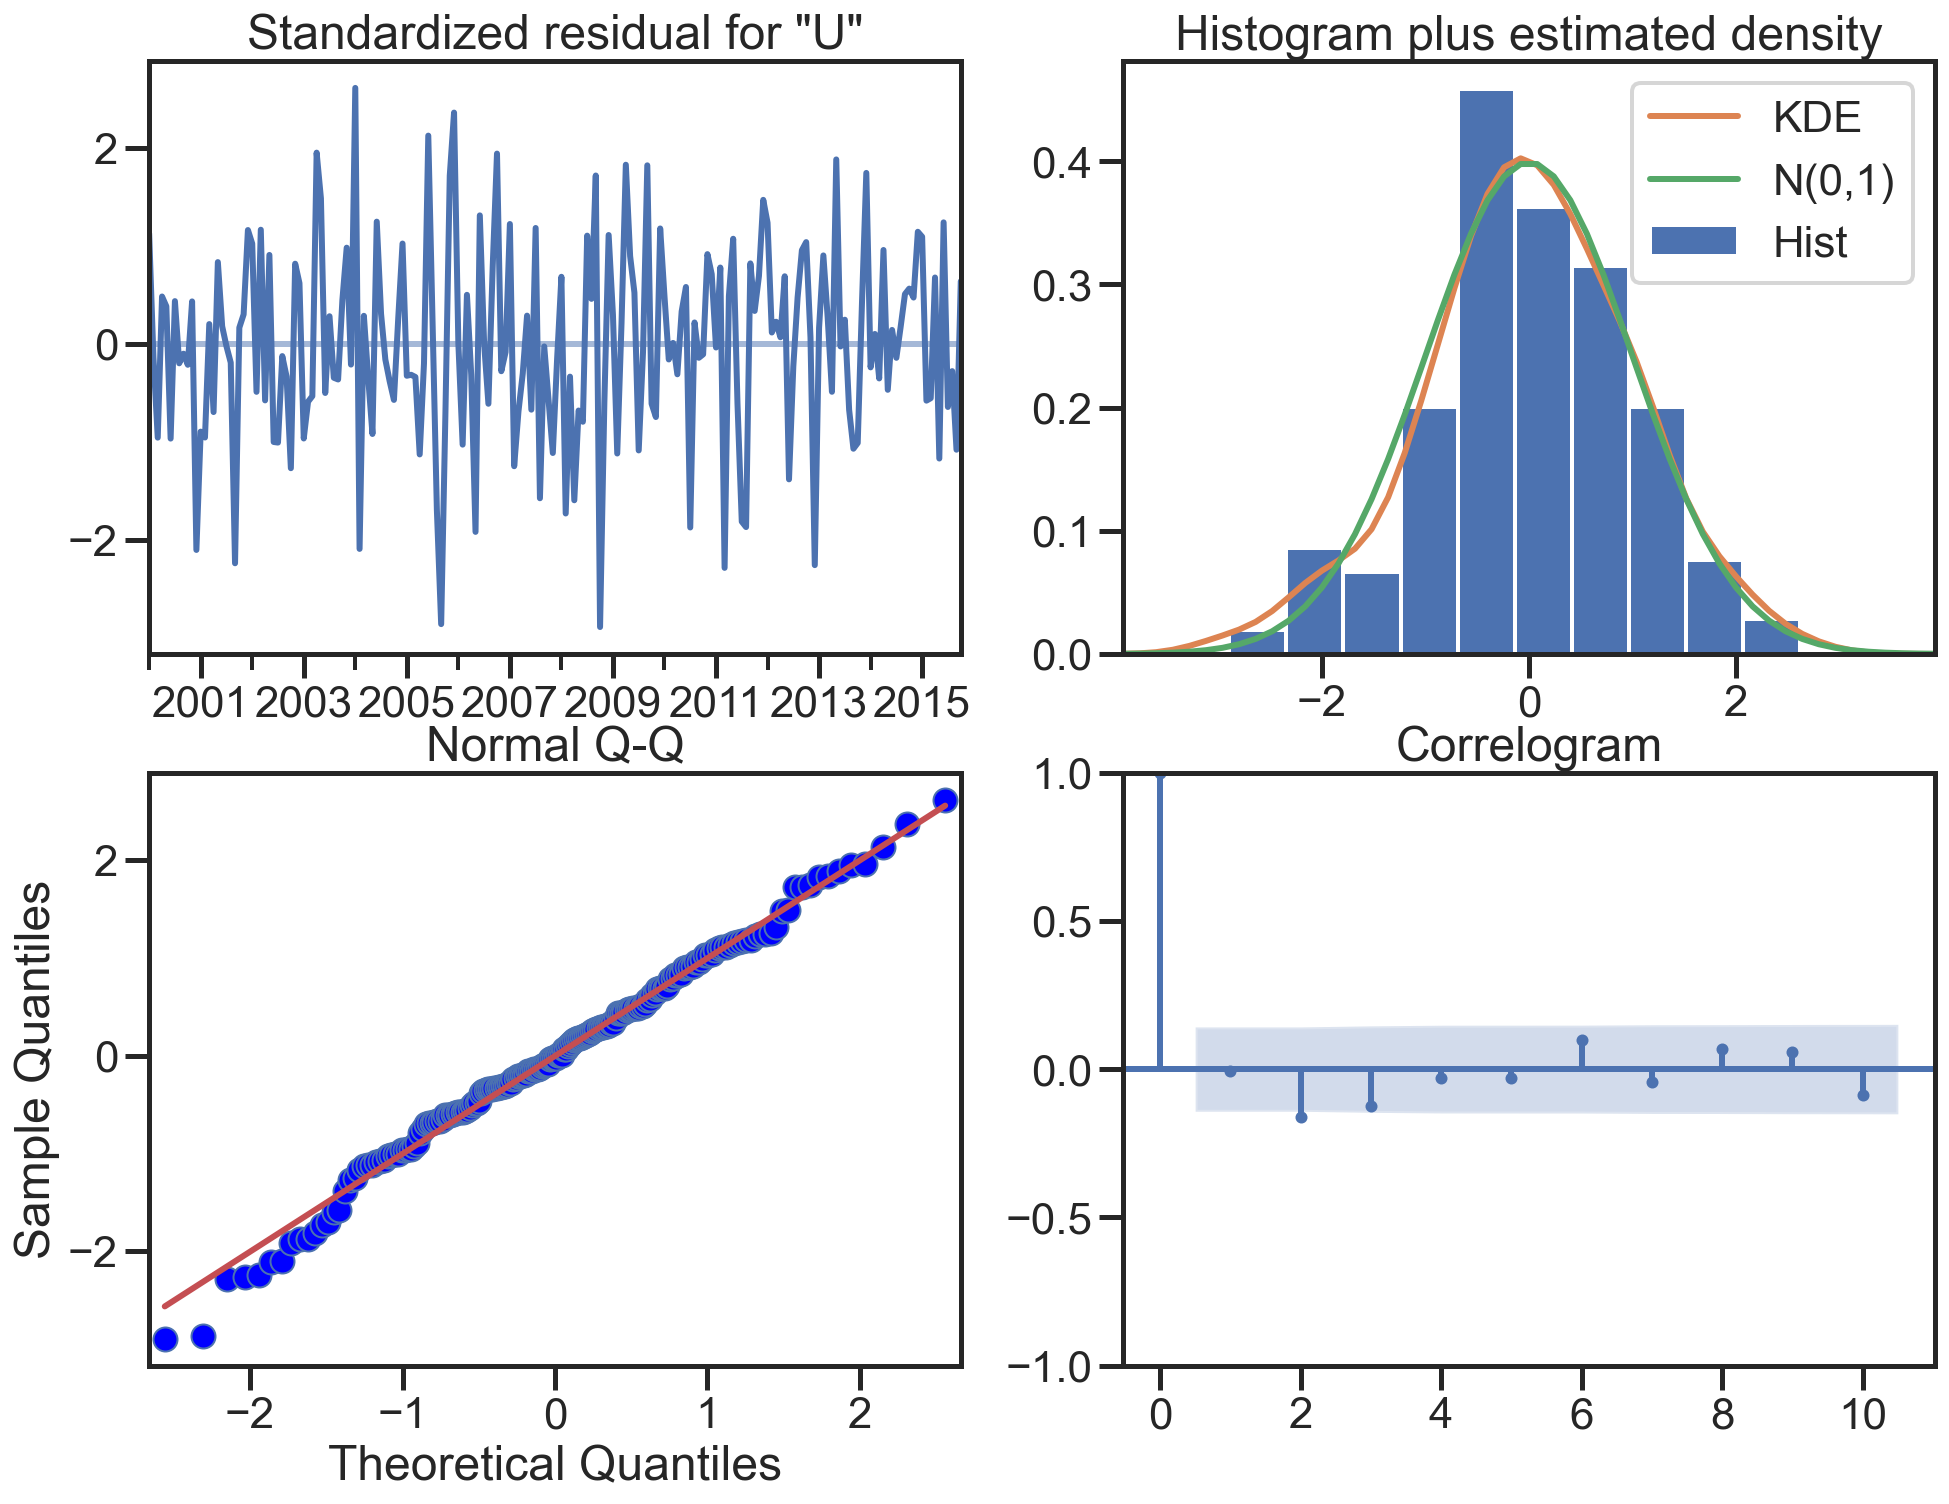

In [12]:
model_results.plot_diagnostics(figsize=(16, 12));
